(73740, 51661)
597


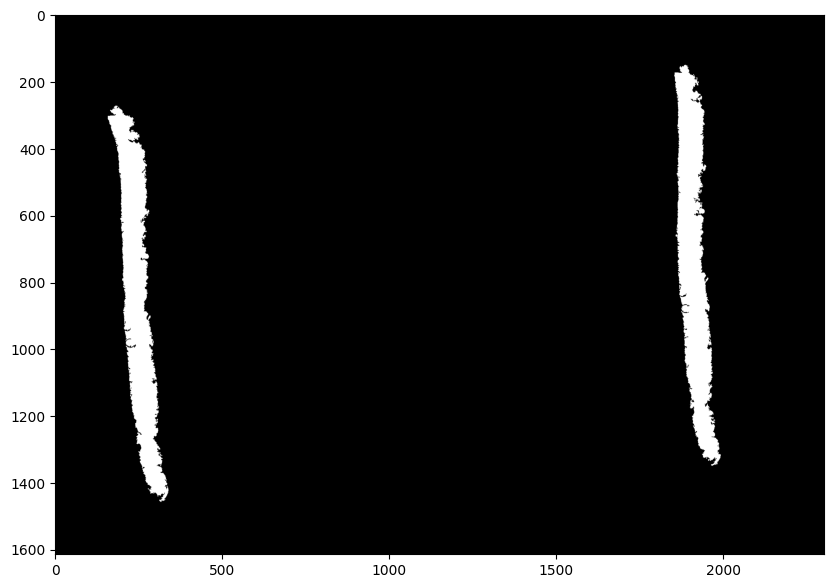

In [1]:
import cv2
import tiffslide as openslide
import numpy as np

import logging 

class Slide:
    def __init__(self, config, svsName) -> None:
        self.config = config
        self.svsName = svsName
        self.svsPath = f"{self.config['svsBase']}/{self.svsName}"
        self.s = openslide.open_slide(self.svsPath)

    def smoothBinary(self, mask):
        kn = 2
        iterat = 2
        kernel = np.ones((kn, kn), np.uint8) 
        for _ in range(iterat):
            mask = cv2.erode(mask, kernel, iterations=1) 
            mask = cv2.dilate(mask, kernel, iterations=1) 
        return mask

    def extractForeground(self):
        location = (0,0)
        level = self.s.level_count-1
        size = self.s.level_dimensions[self.s.level_count-1]
        lr = np.array(self.s.read_region(location, level, size))[:,:,:3]

        lrGray = cv2.cvtColor(lr, cv2.COLOR_RGB2GRAY)

        _, thre = cv2.threshold(lrGray, 220, 255, cv2.THRESH_BINARY) # THreshold for White
        threTissue = 255-thre

        self.threTissueSmooth = self.smoothBinary(threTissue)

        thresholdArea = 0.7
        contours, _ = cv2.findContours(self.threTissueSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        c_max = max(contours, key = cv2.contourArea)
        area_min = cv2.contourArea(c_max) * thresholdArea

        contours_filtered = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_min:
                contours_filtered.append(contour)

        im_ = lrGray*0

        cv2.drawContours(im_, contours_filtered, -1, 255, -1)

        self.threTissueSmooth = np.copy(im_)
                
        return self.threTissueSmooth

    def extractPatches(self, patchSize):
        (w, h) = self.s.level_dimensions[0]
        wn = w//patchSize
        hn = h//patchSize
        self.threTissueSmoothResized = cv2.resize(self.threTissueSmooth, (wn, hn)) # Resize Binary Mask to align with Patches

        self.patches = {}

        for ix in range(wn):
            for iy in range(hn):
                if self.threTissueSmoothResized[iy, ix]==255:
                    try:
                        x = ix*patchSize
                        y = iy*patchSize
                        size = (patchSize, patchSize)
                        level = 0
                        location = (x,y)
                        self.patches[f'{x}_{y}'] = cv2.cvtColor(np.array(self.s.read_region(location, level, size))[:,:,:3], cv2.COLOR_RGB2BGR)
                    except:
                        logging.warning("Exception inside patch extraction")
        
        return self.patches

slideName = '31-10001_PAS_2of2.svs'
patchSize = 512

config = {
    'svsBase': '/blue/pinaki.sarder/nlucarelli/kpmp_new',
    'patchSize': 512
}

slide = Slide(config, slideName)

w, h = slide.s.level_dimensions[0]

fg = slide.extractForeground()

slide.extractPatches(patchSize)

print((w, h))

print(len(slide.patches))

import matplotlib.pyplot as plt

%matplotlib inline

keys = list(slide.patches)

fig = plt.figure(figsize = (20,7))

plt.imshow(fg, cmap='gray')





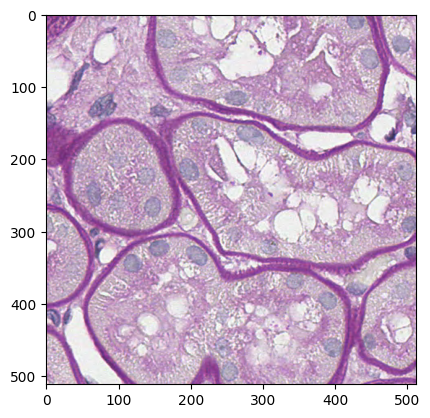

In [3]:
im = cv2.cvtColor(slide.patches[keys[10]], cv2.COLOR_BGR2RGB)

plt.imshow(im)


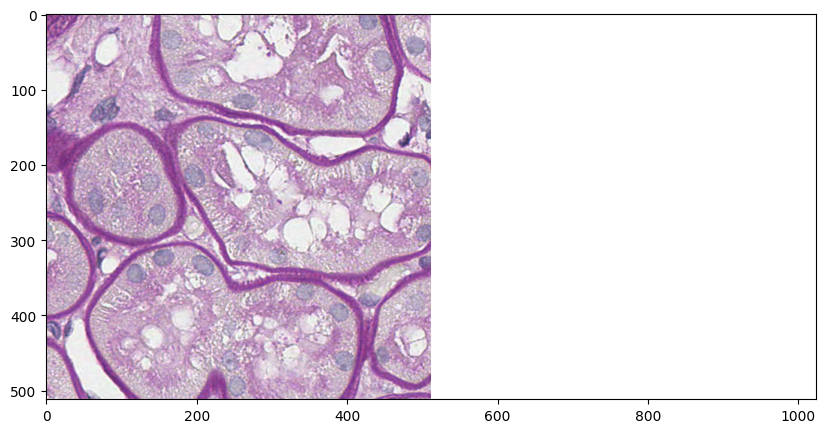

In [18]:
def segmentLumen(im):
    def applyThresholdWhite(patch):

        hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
        h = hsv[:,:,0]
        lower = 0
        upper = 125
        mask = cv2.inRange(h, lower, upper)
        
        return np.array(mask, dtype='uint8')

    def smoothBinary(mask):
        kn = 3
        iterat = 3
        kernel = np.ones((kn, kn), np.uint8) 
        for _ in range(iterat):
            mask = cv2.erode(mask, kernel, iterations=1) 
            mask = cv2.dilate(mask, kernel, iterations=1) 
        return mask

    thresholdArea = 0.4

    mask = applyThresholdWhite(im)
    # maskSmooth = smoothBinary(mask)
    maskSmooth = mask
    mask3d = cv2.cvtColor(maskSmooth, cv2.COLOR_GRAY2RGB)

    #contours, _ = cv2.findContours(maskSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours, hierarchy = cv2.findContours(maskSmooth, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(maskSmooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    c_max = max(contours, key = cv2.contourArea)
    area_min = cv2.contourArea(c_max) * thresholdArea

    contours_filtered = []

    amin = 1

    for contour, hie in zip(contours, hierarchy[0]):
        area = cv2.contourArea(contour)
        if area > area_min:
            if area > amin:
                contours_filtered.append(contour)

    return contours_filtered

contours_filtered = segmentLumen(im)
    
im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (255, 255, 255), -1)

concat = cv2.hconcat((im, im_))

fig = plt.figure(figsize = (15,5))

plt.imshow(concat)


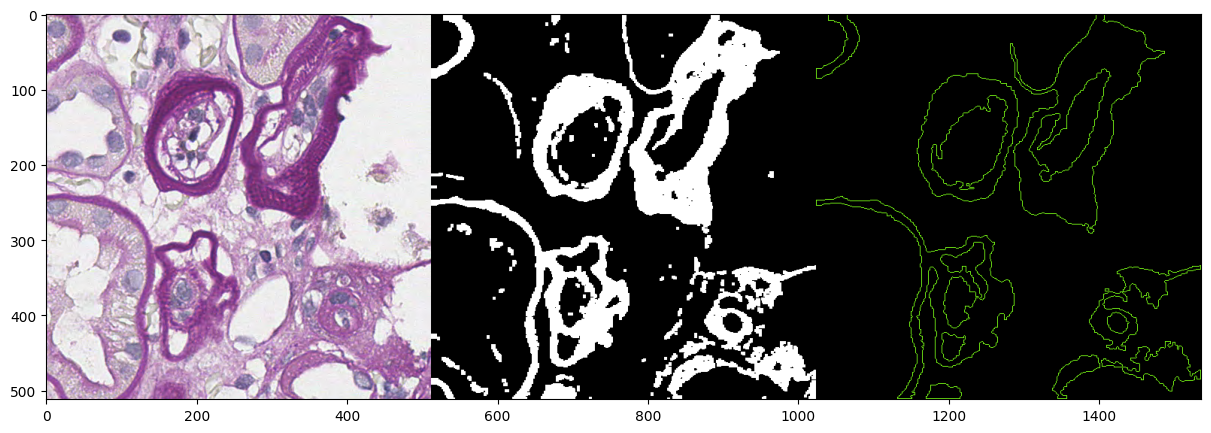

In [7]:
im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (123, 255, 23), 1)

concat = cv2.hconcat((im, mask3d, im_))

fig = plt.figure(figsize = (15,5))

plt.imshow(concat)
